## DEEP LEARNING METHODS FOR INTERESTS POINTS DETECTION IN IMAGES

# 1. Imports and Setup

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC

C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Deliverables: 
Required libraries are imported including TensorFlow, Keras, OpenCV, NumPy, and Matplotlib.

# 2. Directory and Data Preparation

In [3]:
base_dir = r'C:\Users\hp\OneDrive\Other_Projects\Shishi\Dissertation\Code\training'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
img_height, img_width = 128, 128
batch_size = 32

Deliverables: 
Base directory path is set
Training and testing directory paths are set
Image dimensions and batch size are defined.

# 3. Data Augmentation and Generators

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1460 images belonging to 2 classes.
Found 1460 images belonging to 2 classes.


Deliverables: 
Data augmentation for training data
Data normalization for test data
Train and validation data generators.

# 4. Custom F1 Score Metric

In [5]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

Deliverables:
Custom F1 Score metric for model evaluation.

# 5. CNN Model Definition and Training

In [6]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC(), F1Score()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

cnn_history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

cnn_model.save('cnn_model.h5')
print("CNN model saved.")



Epoch 1/10


46/46 [==============================] - ETA: 0s - loss: 8.2890 - accuracy: 0.4904 - precision: 0.4867 - recall: 0.3521 - auc: 0.4917 - f1_score: 0.4086

C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


46/46 [==============================] - 118s 3s/step - loss: 8.2890 - accuracy: 0.4904 - precision: 0.4867 - recall: 0.3521 - auc: 0.4917 - f1_score: 0.4086 - val_loss: 6.3654 - val_accuracy: 0.6096 - val_precision: 0.6303 - val_recall: 0.5301 - val_auc: 0.6467 - val_f1_score: 0.5759 - lr: 1.0000e-04
Epoch 2/10
46/46 [==============================] - 64s 1s/step - loss: 5.0577 - accuracy: 0.5247 - precision: 0.5393 - recall: 0.3384 - auc: 0.5471 - f1_score: 0.4158 - val_loss: 3.8928 - val_accuracy: 0.5781 - val_precision: 0.5478 - val_recall: 0.8945 - val_auc: 0.6292 - val_f1_score: 0.6795 - lr: 1.0000e-04
Epoch 3/10
46/46 [==============================] - 63s 1s/step - loss: 3.1249 - accuracy: 0.5445 - precision: 0.5915 - recall: 0.2877 - auc: 0.5886 - f1_score: 0.3871 - val_loss: 2.4430 - val_accuracy: 0.6205 - val_precision: 0.5903 - val_recall: 0.7877 - val_auc: 0.6418 - val_f1_score: 0.6749 - lr: 1.0000e-04
Epoch 4/10
46/46 [==============================] - 95s 2s/step - loss:

C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CNN model saved.


Deliverables:
Definition of the CNN model architecture.
Compilation of the CNN model with Adam optimizer and custom metrics.
Early stopping and learning rate reduction callbacks.
Training of the CNN model.
Saving the trained CNN model.

# 6. CNN Model Prediction and Visualization

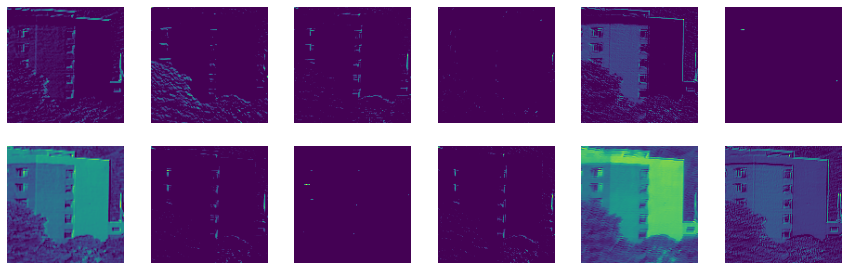

The model predicts that the image is not forged.


In [45]:
@tf.function
def predict_with_model(model, img):
    return model(img, training=False)

def visualize_cnn_keypoints(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    img_resized = cv2.resize(img, (img_height, img_width))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model(img_resized)
    
    first_layer_activation = activations[0]
    plt.figure(figsize=(15, 15))
    for i in range(12):
        plt.subplot(6, 6, i + 1)
        plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

    prediction = predict_with_model(model, img_resized)
    if prediction[0] >= 0.6:
        print("The model predicts that the image is forged.")
    else:
        print("The model predicts that the image is not forged.")

sample_image_path = os.path.join(base_dir, r'sample\org1.jpg')

visualize_cnn_keypoints(sample_image_path, cnn_model)

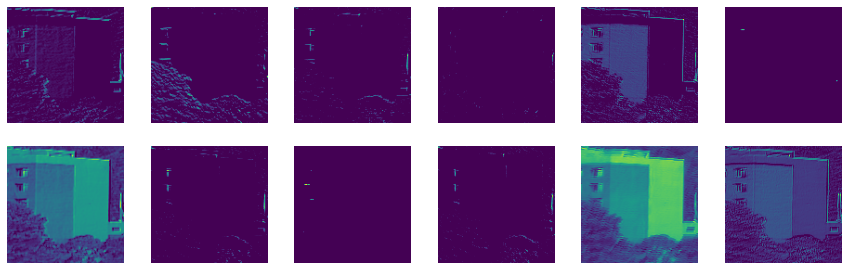

The model predicts that the image is forged.


In [51]:
@tf.function
def predict_with_model(model, img):
    return model(img, training=False)

def visualize_cnn_keypoints(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    img_resized = cv2.resize(img, (img_height, img_width))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model(img_resized)
    
    first_layer_activation = activations[0]
    plt.figure(figsize=(15, 15))
    for i in range(12):
        plt.subplot(6, 6, i + 1)
        plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

    prediction = predict_with_model(model, img_resized)
    if prediction[0] >= 0.5:
        print("The model predicts that the image is forged.")
    else:
        print("The model predicts that the image is not forged.")

sample_image_path = os.path.join(base_dir, r'sample\fg1.jpg')

visualize_cnn_keypoints(sample_image_path, cnn_model)

Deliverables:
Function to make predictions using the CNN model.
Visualization of CNN keypoints.
Example visualization on a sample image.

# 7. Sequence Preparation for RNN

In [8]:
sequence_length = 10

def create_sequences(generator, sequence_length):
    X, y = [], []
    for _ in range(len(generator)):
        batch_x, batch_y = generator.next()
        for i in range(0, len(batch_x) - sequence_length + 1):
            X.append(batch_x[i:i + sequence_length])
            y.append(batch_y[i + sequence_length - 1])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_generator, sequence_length)
X_val, y_val = create_sequences(validation_generator, sequence_length)

Deliverables:
Function to create sequences of images for RNN input.
Creation of training and validation sequences.

# 8. RNN Model Definition and Training

In [9]:
rnn_model = Sequential([
    TimeDistributed(cnn_model, input_shape=(sequence_length, img_height, img_width, 3)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC(), F1Score()])

rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

rnn_model.save('rnn_model.h5')
print("RNN model saved.")

Epoch 1/10
33/33 [==============================] - 527s 14s/step - loss: 0.7089 - accuracy: 0.5182 - precision_2: 0.5210 - recall_2: 0.2412 - auc_1: 0.5087 - f1_score: 0.3298 - val_loss: 0.6978 - val_accuracy: 0.5239 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_1: 0.5000 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
33/33 [==============================] - 287s 9s/step - loss: 0.6958 - accuracy: 0.4876 - precision_2: 0.3830 - recall_2: 0.0700 - auc_1: 0.4816 - f1_score: 0.1184 - val_loss: 0.6938 - val_accuracy: 0.5239 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_1: 0.5000 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
33/33 [==============================] - 261s 8s/step - loss: 0.6939 - accuracy: 0.5067 - precision_2: 0.4167 - recall_2: 0.0097 - auc_1: 0.4833 - f1_score: 0.0190 - val_loss: 0.6927 - val_accuracy: 0.5239 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_1: 0.5000 - val_f1_score: 0.0000e+00 - 

Deliverables:
Definition of the RNN model architecture using the CNN model for feature extraction.
Compilation of the RNN model with Adam optimizer and custom metrics.
Training of the RNN model.
Saving the trained RNN model.

# 9. Plotting and Summarizing Metrics

In [10]:
def plot_metrics(history, title):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    if 'precision' in history.history:
        plt.subplot(3, 2, 3)
        plt.plot(history.history['precision'], label='Train Precision')
        plt.plot(history.history['val_precision'], label='Validation Precision')
        plt.legend()
        plt.title(f'{title} - Precision')

    if 'recall' in history.history:
        plt.subplot(3, 2, 4)
        plt.plot(history.history['recall'], label='Train Recall')
        plt.plot(history.history['val_recall'], label='Validation Recall')
        plt.legend()
        plt.title(f'{title} - Recall')

    if 'auc' in history.history:
        plt.subplot(3, 2, 5)
        plt.plot(history.history['auc'], label='Train AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.legend()
        plt.title(f'{title} - AUC')

    if 'f1_score' in history.history:
        plt.subplot(3, 2, 6)
        plt.plot(history.history['f1_score'], label='Train F1 Score')
        plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
        plt.legend()
        plt.title(f'{title} - F1 Score')

    plt.tight_layout()
    plt.show()

In [11]:
def summarize_metrics(history, title):
    metrics = ['accuracy', 'precision', 'recall', 'auc', 'f1_score']
    for metric in metrics:
        train_metric = history.history.get(metric, [None])[-1]
        val_metric = history.history.get(f'val_{metric}', [None])[-1]
        print(f'{title} - Final {metric.capitalize()}:')
        print(f'  Train {metric.capitalize()}: {train_metric}')
        print(f'  Validation {metric.capitalize()}: {val_metric}\n')



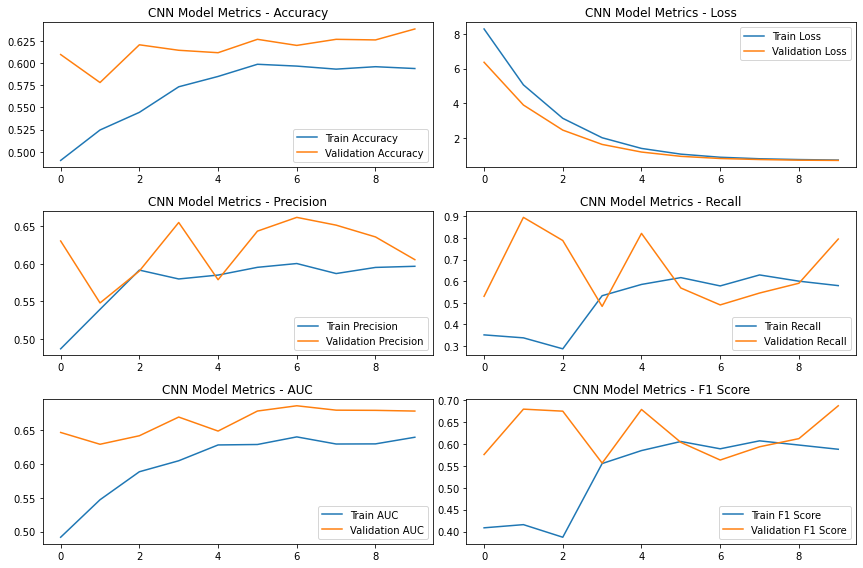

In [12]:
plot_metrics(cnn_history, "CNN Model Metrics")

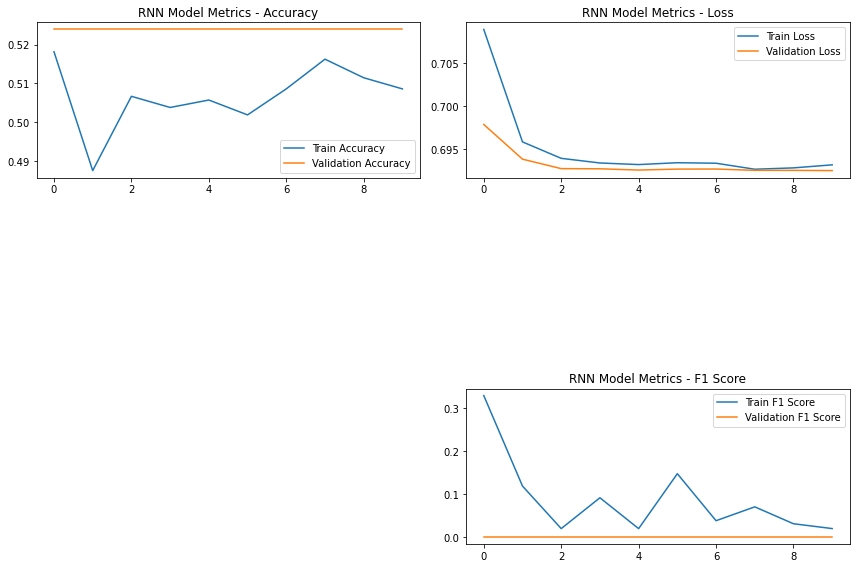

In [13]:
plot_metrics(rnn_history, 'RNN Model Metrics')

In [14]:
print("CNN Model Performance Summary:")
summarize_metrics(cnn_history, "CNN Model")

CNN Model Performance Summary:
CNN Model - Final Accuracy:
  Train Accuracy: 0.5938355922698975
  Validation Accuracy: 0.6383561491966248

CNN Model - Final Precision:
  Train Precision: 0.5966149568557739
  Validation Precision: 0.6054279804229736

CNN Model - Final Recall:
  Train Recall: 0.5794520378112793
  Validation Recall: 0.7945205569267273

CNN Model - Final Auc:
  Train Auc: 0.6396200060844421
  Validation Auc: 0.6783636808395386

CNN Model - Final F1_score:
  Train F1_score: 0.5879082083702087
  Validation F1_score: 0.6872037053108215



In [15]:
print("RNN Model Performance Summary:")
summarize_metrics(rnn_history, 'RNN Model')

RNN Model Performance Summary:
RNN Model - Final Accuracy:
  Train Accuracy: 0.5086042284965515
  Validation Accuracy: 0.52390056848526

RNN Model - Final Precision:
  Train Precision: None
  Validation Precision: None

RNN Model - Final Recall:
  Train Recall: None
  Validation Recall: None

RNN Model - Final Auc:
  Train Auc: None
  Validation Auc: None

RNN Model - Final F1_score:
  Train F1_score: 0.019083965569734573
  Validation F1_score: 0.0



Deliverables:
Plotting of training and validation metrics for both models.
Summarizing the final metrics for both models.

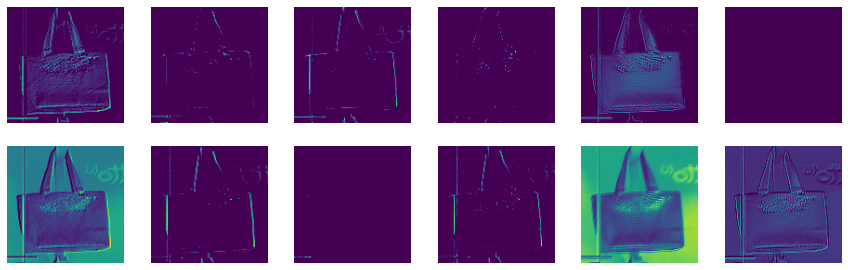

The model predicts that the image is not forged.


In [53]:
@tf.function
def predict_with_model(model, img):
    return model(img, training=False)

def visualize_cnn_keypoints(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    img_resized = cv2.resize(img, (img_height, img_width))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model(img_resized)
    
    first_layer_activation = activations[0]
    plt.figure(figsize=(15, 15))
    for i in range(12):
        plt.subplot(6, 6, i + 1)
        plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

    prediction = predict_with_model(model, img_resized)
    if prediction[0] >= 0.6:
        print("The model predicts that the image is forged.")
    else:
        print("The model predicts that the image is not forged.")

sample_image_path = os.path.join(base_dir, r'sample\org3.jpg')

visualize_cnn_keypoints(sample_image_path, cnn_model)

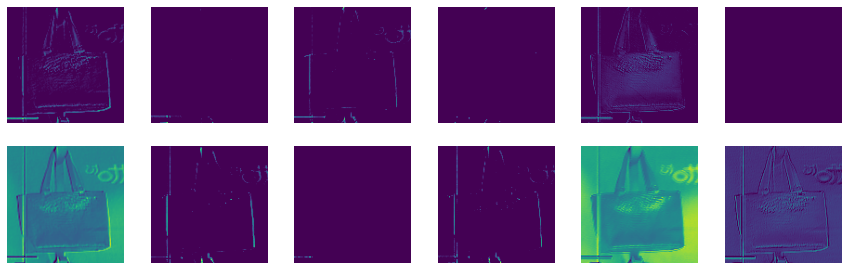

The model predicts that the image is forged.


In [52]:
@tf.function
def predict_with_model(model, img):
    return model(img, training=False)

def visualize_cnn_keypoints(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    img_resized = cv2.resize(img, (img_height, img_width))
    img_resized = img_resized / 255.0
    img_resized = np.expand_dims(img_resized, axis=0)

    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model(img_resized)
    
    first_layer_activation = activations[0]
    plt.figure(figsize=(15, 15))
    for i in range(12):
        plt.subplot(6, 6, i + 1)
        plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

    prediction = predict_with_model(model, img_resized)
    if prediction[0] >= 0.5:
        print("The model predicts that the image is forged.")
    else:
        print("The model predicts that the image is not forged.")

sample_image_path = os.path.join(base_dir, r'sample\fg3.jpg')

visualize_cnn_keypoints(sample_image_path, cnn_model)